### Nearest Neighbor Analysis with SafeGraph spending data
1. Import modules and sign in
2. Read in SafeGraph spending data and nursing home locations
3. Explore spatial distribuction of SafeGraph spending data
4. Find nearest neighbors of spending data points for each nursing home
5. Compare the spending amount and types with points near nursing homes and those of hospitals
6. Save output to feature service

In [0]:
import geoanalytics
from geoanalytics.tools import *
from geoanalytics.tools import NearestNeighbors
from pyspark.sql import functions as F
from geoanalytics.sql import functions as ST
geoanalytics.auth(username="gae_dev", password=dbutils.secrets.get(scope="my-secret", key="pwd"))
spark.conf.set("fs.azure.account.key.gaxstorage.dfs.core.windows.net", 
               dbutils.secrets.get(scope="my-secret", key="secretkey"))

#### Read in SafeGraph spending data and nursing homes locations
1. Read in the SafeGraph spending parquet dataset from Azure Data Lake
2. Construct geometry field and set time field of the SafeGraph spedining DataFrame
3. Read in nursing home shapefile dataset from Azure Data Lake

In [0]:
# Load the data from Azure Data Lake
sg_spend = spark.read.parquet(r"abfss://data_path_to_sg_spend_patterns")
print("Count of spending records: " + str(sg_spend.count()))

# construct geometry field and set time field
sg_spend_geom = sg_spend.withColumn("point", ST.point("longitude", "latitude", 5070)) \
                 .select("point", "in_person_spend", "start_time", "top_category", "sub_category", "city") \
                 .st.set_time_fields("start_time")  

# load mobilde home parks shapefile data 
df_nursing_home = spark.read.format("shapefile").load(r"abfss://data_path_to_nursing_homes") \
    .select("NAME", "ADDRESS", "OBJECTID", "geometry", "STATE", "CITY")

Count of spending records: 49600542


#### Aggregate SafeGraph points data into H3 bins

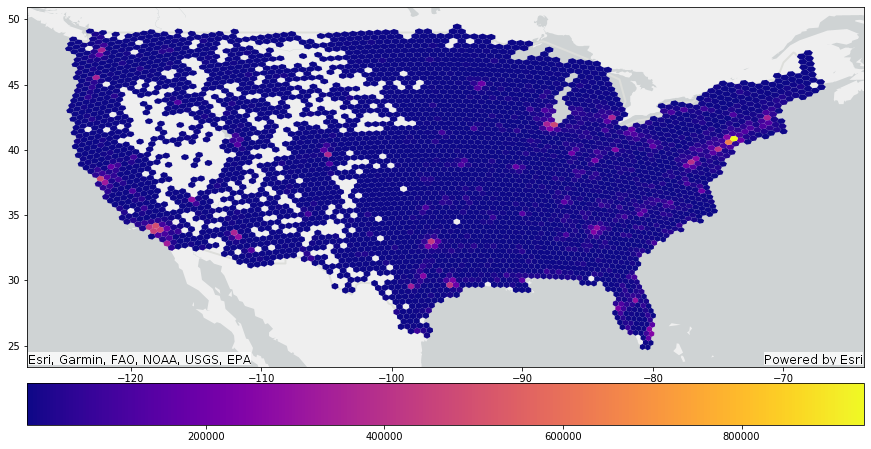

In [0]:
# Aggregate points of SafeGraph spending data locations
ap = AggregatePoints().setBins(bin_size=4, bin_size_unit="h3res", bin_type="h3").run(sg_spend_geom)
ap_plot = ap.st.plot(geometry="bin_geometry", 
                     basemap="light", 
                     cmap_values="COUNT", 
                     cmap="plasma", 
                     figsize=(15, 15), 
                     legend=True, 
                     legend_kwds={"orientation": "horizontal", "location": "bottom", "pad": 0.02})

#### Find nearest in-person spending points for each nursing home

In [0]:
result_long = NearestNeighbors() \
            .setNumNeighbors(3) \
            .setSearchDistance(1, "Kilometer") \
            .setResultLayout("long") \
            .run(df_nursing_home, sg_spend_geom)

result_long.createOrReplaceTempView("result_long")
result_long = spark.sql("SELECT *, ST_shortestline(point, geometry) as shortest_line FROM result_long")
result_long.show(3)

+-----------------+--------------------+--------+--------------------+-----+----+---------+------------------+--------------------+---------------+-------------------+--------------------+------------+-----+--------------------+
|             NAME|             ADDRESS|OBJECTID|            geometry|STATE|CITY|near_rank|     near_distance|               point|in_person_spend|         start_time|        top_category|sub_category|city1|       shortest_line|
+-----------------+--------------------+--------+--------------------+-----+----+---------+------------------+--------------------+---------------+-------------------+--------------------+------------+-----+--------------------+
|THE LAKES OF NOVI|41795 TWELVE MILE...|   20631|{"x":-83.46019131...|   MI|NOVI|        1|384.94524008565395|{"x":-83.46421700...|        1292.31|2020-07-01 04:00:00|Nursing and Resid...|        null| Novi|{"paths":[[[-83.4...|
|THE LAKES OF NOVI|41795 TWELVE MILE...|   20631|{"x":-83.46019131...|   MI|NOVI|   

#### Plot result of Nearest Neighbors tool
1. Sample 1% of the SafeGraph dataset and run Nearest Neighbors analysis with it
2. Use ST_shortestline to create lines between each nursing home locations and its nearest spending points
3. Plot result with a defined extent

In [0]:
sg_spend_sample = spark.read.parquet(r"abfss://demo@gaxstorage.dfs.core.windows.net/sg_spend_patterns_50m").sample(0.01)

sg_spend_geom_sample = sg_spend_sample.withColumn("point", ST.point("longitude", "latitude", 5070)) \
                 .select("point", "in_person_spend", "start_time", "top_category", "sub_category") \
                 .st.set_time_fields("start_time")

result_long_sample = NearestNeighbors() \
            .setNumNeighbors(3) \
            .setSearchDistance(1, "Kilometer") \
            .setResultLayout("long") \
            .run(df_nursing_home, sg_spend_geom_sample)
            
result_long_sample.createOrReplaceTempView("result_long_sample")
result_long_sample = spark.sql("SELECT *, ST_shortestline(point, geometry) as shortest_line FROM result_long_sample")
# result_long_sample = result_long_sample.withColumn("shortest_line", ST.shortest_line("point", "geometry"))

Out[40]: Text(50.5, 0.5, 'Y (Meters)')

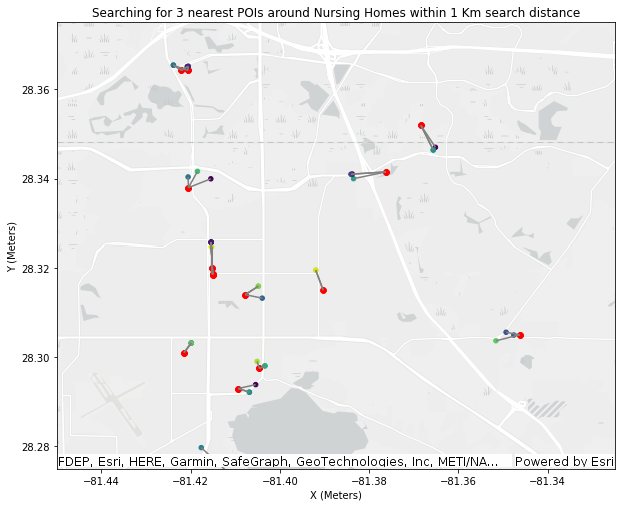

In [0]:
# visualization
defined_extent = (-81.45, 28.275, -81.325, 28.375)
nursing_homes = result_long_sample.where("STATE == 'FL'").st.plot(geometry="geometry", basemap="light", 
                                          marker_size=30, color="red", figsize=(10,10), extent=defined_extent)

person_spending = result_long_sample.where("STATE == 'FL'").st.plot(geometry="point", basemap="light", 
                                                                    marker_size=20, cmap_values="top_category", 
                                                                    figsize=(10,10), ax=nursing_homes, extent=defined_extent)

result_plot = result_long_sample.where("STATE == 'FL'").st.plot(geometry="shortest_line", basemap="light", 
                                                                color="grey", figsize=(10,10), ax=person_spending, extent=defined_extent)

result_plot.set_title("Searching for 3 nearest POIs around Nursing Homes within 1 Km search distance")
result_plot.set_xlabel("X (Meters)")
result_plot.set_ylabel("Y (Meters)")


#### Compare the spending patterns with points near nursing home and those of the other facilities
1. Run Nearest Neighbors analysis with hopistals locations in US and SafeGraph spending data
2. find the average spending on the top 10 types of spending categories of
    - spending points near nursing homes
    - spending points near hospitals
3. Compare them in a bar graph

In [0]:
df_hospitals = spark.read.format("shapefile").load(r"abfss://demo@gaxstorage.dfs.core.windows.net/Hospitals") \
    .select("NAME", "ADDRESS", "OBJECTID", "geometry", "STATE", "CITY")
hospital_long = NearestNeighbors() \
            .setNumNeighbors(3) \
            .setSearchDistance(1, "Kilometer") \
            .setResultLayout("long") \
            .run(df_hospitals, sg_spend_geom)

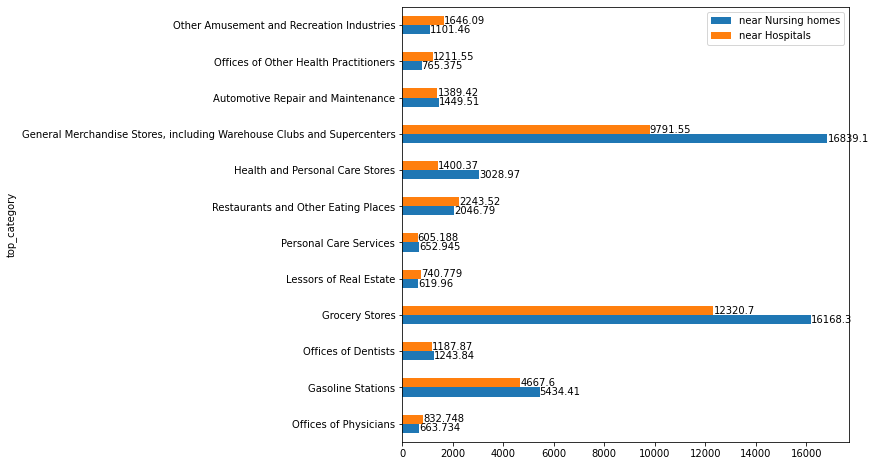

In [0]:
top_10_spending = result_long.groupBy("top_category").count().sort("count", ascending=False).limit(12)
filter_list = [row["top_category"] for row in top_10_spending.collect()]
nursing_home_agg = result_long.groupBy("top_category").agg(F.avg("in_person_spend").alias("avg_spending")) \
                    .withColumnRenamed("avg_spending", "near Nursing homes") \
                    .filter(sg_spend_geom["top_category"].isin(filter_list))
hospital_agg = hospital_long.groupBy("top_category").agg(F.avg("in_person_spend").alias("near Hospitals")) \
                    .filter(result_long["top_category"].isin(filter_list))
df_join = nursing_home_agg.join(hospital_agg, "top_category")
ax = df_join.toPandas().plot(kind="barh", x='top_category', figsize=(8,8))
for container in ax.containers:
    ax.bar_label(container)

#### Save output as feature service to ArcGIS Online

In [0]:
username=""
password=""
geoanalytics.register_gis("myGIS", "https://arcgis.com", username=username, password=password)

Out[44]: 'myGIS'

In [0]:
name = 'POIs_near_nursing_home_FL_output'
output = result_long_sample.select("point", "in_person_spend", "start_time", "top_category", "sub_category", "city") \
            .withColumn("point_transform", ST.transform("point", 4326)) \
            .where(ST.bbox_intersects("point_transform", xmin=-81.45, ymin=28.275, xmax=-81.325, ymax=28.375)) \
            .drop("point")        
output.write.format("feature-service") \
    .option("gis", "myGIS") \
    .option("serviceName", name) \
    .option("description", "a subset of Nearest POIs of nursing home in Florida") \
    .save()

In [0]:
geoanalytics.unregister_gis("myGIS")